# Radiointerferometry with Bayesian Image Reconstruction

In this notebook, we will perform image reconstruction of radiointerferometric data via a Bayesian *Maximum a Posteriori* (MAP) approach. 

The forward model defining the blurring process is defined as:

$$\mathbf{y}=\mathbf{H}\mathbf{x}+\mathbf{n}$$

where:

- $\mathbf{y} \in \mathbb{R}^{d}$ is the observed noisy visibilities,
- $\mathbf{H}: \mathbb{R}^{d\times d}$ is the measurement operator, which consists on a non-uniform Fourier transform,
- $\mathbf{x} \in \mathbb{R}^{d}$ is the original image of the sky that we want to recover,
- $\mathbf{n} \in \mathbb{R}^{d}$ is independent and identically distributed Gaussian noise.

In [1]:
# Importing necessary libraries and modules
import os

import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np

from pyxu.operator import NUFFT, L21Norm, Gradient, SquaredL2Norm, PositiveOrthant, PositiveL1Norm
from pyxu.opt.solver import PD3O
from pyxu.util import view_as_complex
from pyxu.opt.stop import RelError, MaxIter



os.environ["RASCIL_DATA"] = "./data/"

from rascil.processing_components import show_image, create_test_image, \
    plot_uvcoverage, plot_visibility
from ska_sdp_func_python.util.coordinate_support import skycoord_to_lmn
from ska_sdp_datamodels.configuration.config_create import (
        create_named_configuration,
    )
from ska_sdp_datamodels.visibility import create_visibility
from ska_sdp_datamodels.science_data_model.polarisation_model import (
        PolarisationFrame,
    )
    

def get_direction_cosines(image):
    _, _, ny, nx = image["pixels"].shape
    lmesh, mmesh = np.meshgrid(np.arange(ny), np.arange(nx))
    ra_grid, dec_grid = image.image_acc.wcs.sub([1, 2]).wcs_pix2world(lmesh, mmesh, 0)
    ra_grid = np.deg2rad(ra_grid)
    dec_grid = np.deg2rad(dec_grid)
    directions = SkyCoord(
        ra=ra_grid.ravel() * u.rad,
        dec=dec_grid.ravel() * u.rad,
        frame="icrs",
        equinox="J2000",
    )
    l, m, _ = skycoord_to_lmn(directions, image.image_acc.phasecentre)
    jacobian = np.sqrt(1 - l**2 - m**2)
    direction_cosines = np.stack([l, m, jacobian - 1.0], axis=-1).reshape(-1, 3)
    return direction_cosines, jacobian


## Loading and Preprocessing the Image

We will use a sample image from the `skimage.data` module and preprocess it to be suitable for the deblurring process. The image is converted to a float type and normalized to have pixel values between 0 and 1.

## Creating the Forward operator

We will create a NUFFT operator to simulate the acquisition process of the interferometry system. 

where:

- $G(x)$ is the Gaussian function,
- $\sigma$ is the standard deviation,
- $\mu$ is the mean.

## Allocating visibilities / Creating Low-SKA configuration

There is no flagged visibility. Skip plotting flagged.


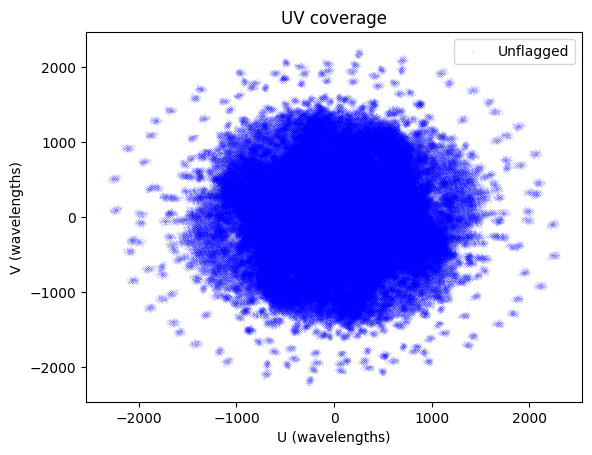

In [2]:
from rascil.processing_components import show_image, create_test_image, \
    plot_uvcoverage, plot_visibility

lowr3 = create_named_configuration("LOWBD2", rmax=3_000.0)
vis = create_visibility(
    config=lowr3,
    times=np.linspace(-4, 4, 9) * np.pi / 12,
    frequency=np.r_[15e7],
    channel_bandwidth=np.r_[5e4],
    weight=1.0,
    phasecentre=SkyCoord(
        ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame="icrs", equinox="J2000"
    ),
    polarisation_frame=PolarisationFrame("stokesI"),
    times_are_ha=False,
)
# Show visibilities
plot_uvcoverage([vis])

### Loading sky GT

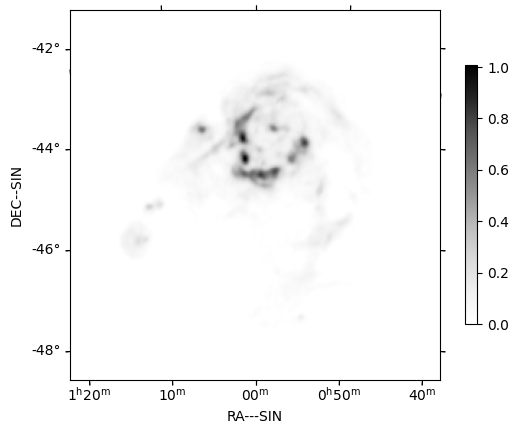

In [3]:
m31image = create_test_image(
        phasecentre=vis.phasecentre, frequency=np.r_[15e7], cellsize=5e-4
)
direction_cosines, jacobian = get_direction_cosines(m31image)
wgt_dirty = 1 / jacobian.reshape(-1)
# Show image
fig=show_image(m31image)

In [4]:
# Creating the NUFFT operator
uvw = vis.visibility_acc.uvw_lambda.reshape(-1, 3)
xyz = direction_cosines.reshape(-1, 3)                              
forward = NUFFT.type3(
    x=xyz, z=2 * np.pi * uvw, real=True, isign=-1,
)

In [5]:
x = m31image.pixels.data.squeeze().copy()

## Applying the Blurring and Adding Noise

We will use the created Gaussian kernel to blur the image and then add Gaussian noise to simulate a real-world scenario where camera sensors are corrupted by thermal noise. Note that the 2D Gaussian kernel is defined in a separable fashion for efficiency reasons. 

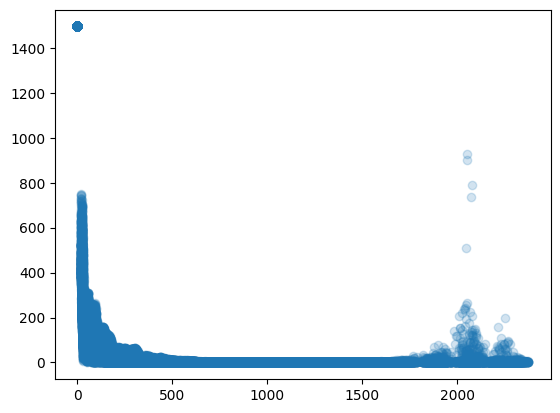

In [6]:
y = forward(x.ravel())
plt.scatter(np.linalg.norm(uvw,axis=1), abs(view_as_complex(y)), alpha=0.2)

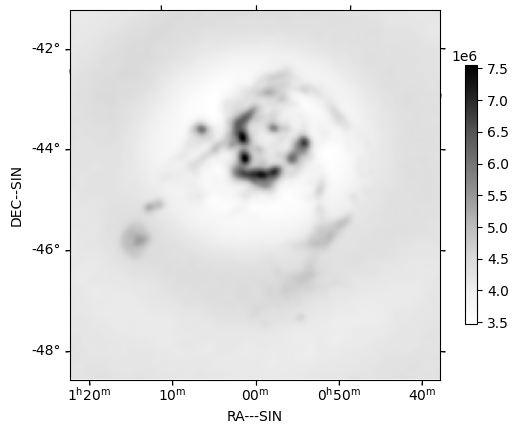

In [9]:
# Getting the dirty image
adjoint_recons = forward.adjoint(y)
adjoint_recons_image = m31image.copy(deep=True)
adjoint_recons_image.pixels.data = adjoint_recons.reshape(adjoint_recons_image.pixels.shape)

show_image(adjoint_recons_image);

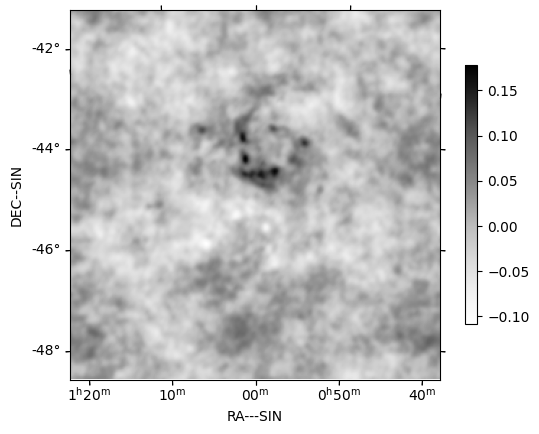

In [6]:

# stop_crit = RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) | MaxIter(500)
# pinv_recons = forward.pinv(y.ravel(), damp=4,  
#                          kwargs_init=dict(show_progress=False, verbosity=50),
#                          kwargs_fit=dict(stop_crit=stop_crit)
#                           )
# pinv_recons_image = m31image.copy(deep=True)
# pinv_recons_image.pixels.data = pinv_recons.reshape(pinv_recons_image.pixels.shape)

# show_image(pinv_recons_image);

## MAP Estimate with Composite Positivity + Total Variation Prior 

Maximum a Posteriori seeks the most credible output given the likelihood and image prior, that is a mode of posterior distribution (not necessarily unique, but globally optimal in the log-concave case). The likelihood model is based on the noise distribution (here assumed Gaussian), and the prior model incorporates our assumptions about the image. The total variation prior promotes "mostly flat" solutions, helping to preserve edges while smoothing out noise. The positivity constraint ensures that the pixel values of the deblurred image remain non-negative.

The MAP optimization problem can be written as:
$$\hat{\mathbf{x}}=\arg\min_{\mathbf{x} ≥0} \frac{1}{2}\Vert \mathbf{y}− \mathbf{H}\mathbf{x}\Vert^{2}_{2}+\lambda\Vert\nabla\mathbf{x}\Vert_{1,2}$$

where:

- $\Vert\mathbf{y}−\mathbf{H}\mathbf{x}\Vert_2^2$ is the squared $L_2$-norm representing the data fidelity term (likelihood),
- $\Vert \nabla \mathbf{x}\Vert_{2, 1}=\sqrt{\Vert \nabla_{x} \mathbf{x} \Vert_{1}^{2} + \Vert \nabla_{y} \mathbf{x}\Vert_{1}^{2}}$ is the isotropic total variation norm,
- $\lambda$ is the regularization parameter,
- $\mathbf{x}≥0$ is the positivity constraint.

We solve this problem with the PD3O solver [🔗](../api/opt.solver.html#pyxu.opt.solver.PD3O), with
 
- $\mathcal{F}(\mathbf{x})=\frac{1}{2}\Vert \mathbf{y}− \mathbf{H}\mathbf{x}\Vert^{2}_{2}$,
- $\mathcal{G}(\mathbf{x})=\iota_+(\mathbf{x})$,
- $\mathcal{H}(\mathbf{z})=\lambda \Vert \mathbf{z}\Vert_{2, 1}$,
- $\mathcal{K}=\nabla$.

PD3O manages the composite, non-smooth, and non-proximable term $\mathcal{H}(\mathcal{K} \mathbf{x})$ utilizing its Fenchel biconjugate. This implies that, while the minimization of the functionals $\mathcal{F}$ and $\mathcal{G}$ occurs on the primal variable of interest, the minimization of the term $\mathcal{H}(\mathcal{K} \mathbf{x})$ is indirectly undertaken on the dual variable, and, upon convergence, subsequently on the primal when the primal-dual gap reduces to zero. Therefore, it is crucial to set the relative improvement convergence threshold of PD3O at a significantly low level to ensure the proper convergence of the algorithm; if not, the resulting solution will not exhibit the mostly flat behavior expected from the application of a Total Variation (TV) prior. A challenge to note is that PD3O, being generically designed, may demonstrate slow convergence when seeking such high accuracies. We can overcome this issue by using the GPU implementation of PD3O, which is significantly faster than the CPU version (e.g., this example runs in approximately 30 seconds in GPU vs. approximately 4 minutes in CPU).

In [10]:
# Setting up the MAP approach with total variation prior and positivity constraint
sl2 = SquaredL2Norm(dim=y.size).asloss(y.ravel())
loss = sl2 * forward

l21 = L21Norm(arg_shape=(2, 256, 256), l2_axis=(0, ))

grad = Gradient(arg_shape=(256, 256))

stop_crit = RelError(
            eps=1e-5,
            var="x",
            f=None,
            norm=2,
            satisfy_all=True,
        ) & RelError(
            eps=1e-5,
            var="z",
            f=None,
            norm=2,
            satisfy_all=True,
        )  | MaxIter(10000)

# positivity = PositiveOrthant(dim=x.size)
l1positivity = PositiveL1Norm(dim=x.size)

In [12]:
x0 = np.zeros(x.size)
print((l21 * grad)(x0))
print(l1positivity(x0))
print(loss(x0))


[0.]
[0.]
[7.39952838e+09]


In [ ]:
# Add all ingredients to the optimizer
solver = PD3O(f=loss, g=l1positivity, h=1e3 * l21, K=grad, verbosity=500)

# Run the optimizer
solver.fit(x0=x0, stop_crit=stop_crit)

INFO -- [2023-11-15 19:30:26.824991] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	RelError[z]: 0.0
	N_iter: 1.0


In [ ]:
solver

In [ ]:
# Getting the clean image
recons_image = m31image.copy(deep=True)
recons_image.pixels.data = solver.solution().reshape(recons_image.pixels.shape)
recons_image.pixels.data.max()

In [ ]:
fig=show_image(recons_image)

## Visualizing the Results

Finally, let's visualize the original image, the blurred and noisy image, and the deblurred image obtained using the MAP approach with a total variation prior and positivity constraint. We will also display the evaluation metrics for a comprehensive comparison.